# Real-Time Face Swapping with Webcam 🎥

This notebook implements **real-time face swapping** using your webcam. It detects faces, applies facial landmarks, and swaps faces on the fly with multiple processing modes.

## Features
- 🔄 **Face Swapping**: Real-time face swap with Delaunay triangulation
- 🌫️ **Blur Anonymization**: Gaussian blur for privacy
- 🔲 **Pixelate Anonymization**: Pixelation effect
- 👤 **Forehead Inclusion**: Extends landmarks to include forehead for better coverage
- 📸 **Screenshot Capture**: Save interesting moments
- 🎯 **Reference Face Capture**: Capture source face directly from webcam
- ⚡ **FPS Tracking**: Monitor performance in real-time

## Controls
- **'q' or ESC**: Quit the application
- **'s'**: Save screenshot
- **'f'**: Face swap mode (default)
- **'b'**: Blur mode
- **'p'**: Pixelate mode
- **'o'**: Original (no processing)
- **'d'**: Toggle debug mode (show landmarks)
- **SPACE**: Capture reference face from webcam

In [12]:
import cv2
import numpy as np
import os
import sys
import time
from datetime import datetime
from scipy.spatial import Delaunay
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt

print("✓ All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6


In [13]:
import urllib.request

landmark_model_path = "lbfmodel.yaml"

if not os.path.exists(landmark_model_path):
    print("⏬ Downloading facial landmark model...")
    url = "https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml"
    
    try:
        urllib.request.urlretrieve(url, landmark_model_path)
        print("✓ Landmark model downloaded successfully!")
    except Exception as e:
        print(f"❌ Could not download model: {e}")
        print("Face swapping will not be available.")
else:
    print("✓ Landmark model already exists!")

✓ Landmark model already exists!


In [14]:
# Initialize face detector (Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print("✓ Face detector loaded")

# Initialize facial landmark detector (LBF)
facemark = None
try:
    facemark = cv2.face.createFacemarkLBF()
    if os.path.exists(landmark_model_path):
        facemark.loadModel(landmark_model_path)
        print("✓ Facial landmark detector loaded")
    else:
        print("⚠ Landmark model not found!")
        facemark = None
except Exception as e:
    print(f"⚠ Could not initialize landmark detector: {e}")
    facemark = None

✓ Face detector loaded
loading data from : lbfmodel.yaml
✓ Facial landmark detector loaded
✓ Facial landmark detector loaded


In [15]:
def estimate_landmarks(face_rect):
    """Estimate facial landmarks from face bounding box (fallback method)."""
    x, y, w, h = face_rect
    landmarks = []
    
    # Face outline (17 points)
    for i in range(17):
        ratio = i / 16.0
        lx = int(x + w * 0.1 + w * 0.8 * ratio)
        ly = int(y + h * (0.2 + 0.6 * abs(ratio - 0.5)))
        landmarks.append([lx, ly])
    
    # Eyebrows (10 points)
    for i in range(5):
        lx = int(x + w * (0.2 + i * 0.08))
        ly = int(y + h * 0.3)
        landmarks.append([lx, ly])
    for i in range(5):
        lx = int(x + w * (0.56 + i * 0.08))
        ly = int(y + h * 0.3)
        landmarks.append([lx, ly])
    
    # Nose (9 points)
    for i in range(9):
        lx = int(x + w * 0.5)
        ly = int(y + h * (0.35 + i * 0.05))
        landmarks.append([lx, ly])
    
    # Eyes (12 points)
    eye_x = x + int(w * 0.3)
    eye_y = y + int(h * 0.4)
    eye_w = int(w * 0.15)
    for i in range(6):
        angle = i * np.pi / 3
        lx = int(eye_x + eye_w * np.cos(angle))
        ly = int(eye_y + eye_w * 0.5 * np.sin(angle))
        landmarks.append([lx, ly])
    
    eye_x = x + int(w * 0.7)
    for i in range(6):
        angle = i * np.pi / 3
        lx = int(eye_x + eye_w * np.cos(angle))
        ly = int(eye_y + eye_w * 0.5 * np.sin(angle))
        landmarks.append([lx, ly])
    
    # Mouth (20 points)
    mouth_y = y + int(h * 0.75)
    mouth_w = int(w * 0.4)
    mouth_x = x + int(w * 0.5)
    
    for i in range(12):
        angle = i * 2 * np.pi / 12
        lx = int(mouth_x + mouth_w * np.cos(angle))
        ly = int(mouth_y + mouth_w * 0.3 * np.sin(angle))
        landmarks.append([lx, ly])
    
    for i in range(8):
        angle = i * 2 * np.pi / 8
        lx = int(mouth_x + mouth_w * 0.6 * np.cos(angle))
        ly = int(mouth_y + mouth_w * 0.2 * np.sin(angle))
        landmarks.append([lx, ly])
    
    return np.array(landmarks, dtype=np.int32)


def extend_landmarks_with_forehead(landmarks, image_shape):
    """Extend landmarks to include forehead points for better face coverage."""
    landmarks = np.array(landmarks, dtype=np.float32)
    
    if len(landmarks) >= 27:
        left_eyebrow = landmarks[19]
        right_eyebrow = landmarks[24]
        nose_bridge = landmarks[27]
        left_face = landmarks[0]
        right_face = landmarks[16]
        
        eyebrow_avg_y = (left_eyebrow[1] + right_eyebrow[1]) / 2
        forehead_height = abs(nose_bridge[1] - eyebrow_avg_y) * 1.5
        
        forehead_points = [
            [left_face[0] + (landmarks[1][0] - left_face[0]) * 0.3, eyebrow_avg_y - forehead_height],
            [left_eyebrow[0], eyebrow_avg_y - forehead_height * 1.1],
            [(left_eyebrow[0] + right_eyebrow[0]) / 2, eyebrow_avg_y - forehead_height * 1.2],
            [right_eyebrow[0], eyebrow_avg_y - forehead_height * 1.1],
            [right_face[0] - (right_face[0] - landmarks[15][0]) * 0.3, eyebrow_avg_y - forehead_height]
        ]
        
        extended = np.vstack([landmarks, forehead_points])
        return extended.astype(np.int32)
    
    return landmarks.astype(np.int32)

print("✓ Landmark helper functions defined")

✓ Landmark helper functions defined


In [16]:
def warp_triangle(img1, img2, t1, t2):
    """Warp a triangle from img1 to img2 using affine transformation."""
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    
    t1_rect = []
    t2_rect = []
    
    for i in range(3):
        t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2_rect), (1.0, 1.0, 1.0), 16, 0)
    
    img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    if img1_rect.size == 0 or r2[2] <= 0 or r2[3] <= 0:
        return
    
    warp_mat = cv2.getAffineTransform(np.float32(t1_rect), np.float32(t2_rect))
    img2_rect = cv2.warpAffine(img1_rect, warp_mat, (r2[2], r2[3]), None,
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    img2_rect = img2_rect * mask
    
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
    
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2_rect

print("✓ Triangle warping function defined")

✓ Triangle warping function defined


In [17]:
def swap_face(source_image, source_landmarks, target_frame, target_landmarks, debug_mode=False):
    """Swap face from source to target using Delaunay triangulation and seamless cloning."""
    if source_image is None or source_landmarks is None:
        return target_frame
    
    try:
        # Extend landmarks to include forehead
        src_extended = extend_landmarks_with_forehead(source_landmarks, source_image.shape)
        dst_extended = extend_landmarks_with_forehead(target_landmarks, target_frame.shape)
        
        # Perform Delaunay triangulation
        tri = Delaunay(dst_extended)
        triangles = tri.simplices
        
        # Convert to float for warping
        src_img = np.float32(source_image)
        dst_img = np.float32(target_frame)
        result = dst_img.copy()
        
        # Warp each triangle
        for triangle_indices in triangles:
            t1 = [src_extended[i] for i in triangle_indices]
            t2 = [dst_extended[i] for i in triangle_indices]
            warp_triangle(src_img, result, t1, t2)
        
        # Create mask and apply seamless cloning
        mask = np.zeros(target_frame.shape[:2], dtype=np.uint8)
        hull = cv2.convexHull(dst_extended)
        cv2.fillConvexPoly(mask, hull, 255)
        mask = cv2.GaussianBlur(mask, (3, 3), 0)
        
        r = cv2.boundingRect(hull)
        center = (r[0] + r[2] // 2, r[1] + r[3] // 2)
        
        result = np.uint8(result)
        output = cv2.seamlessClone(result, target_frame, mask, center, cv2.NORMAL_CLONE)
        
        # Draw landmarks if debug mode
        if debug_mode:
            for (lx, ly) in dst_extended:
                cv2.circle(output, (int(lx), int(ly)), 1, (0, 255, 0), -1)
        
        return output
        
    except Exception as e:
        if debug_mode:
            print(f"Face swap error: {e}")
        return target_frame

print("✓ Face swapping function defined")

✓ Face swapping function defined


In [18]:
def blur_face(frame, face_rect):
    """Apply Gaussian blur to face region for anonymization."""
    x, y, w, h = face_rect
    face_region = frame[y:y+h, x:x+w]
    blurred = cv2.GaussianBlur(face_region, (99, 99), 30)
    frame[y:y+h, x:x+w] = blurred
    return frame


def pixelate_face(frame, face_rect):
    """Apply pixelation to face region for anonymization."""
    x, y, w, h = face_rect
    face_region = frame[y:y+h, x:x+w]
    small = cv2.resize(face_region, (16, 16), interpolation=cv2.INTER_LINEAR)
    pixelated = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
    frame[y:y+h, x:x+w] = pixelated
    return frame

print("✓ Anonymization functions defined")

✓ Anonymization functions defined


Loading source face from: ../assets/Julien.png
✓ Source face loaded with 68 landmarks


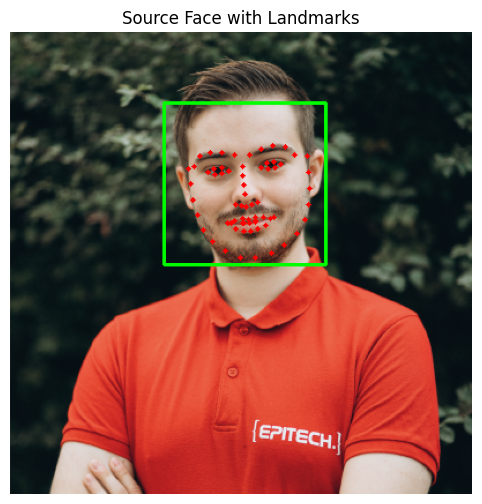

In [19]:
# Global variables for source face
source_image = None
source_landmarks = None
source_face = None

# Load source face image (change this path to your image)
source_image_path = "../assets/Julien.png"

if os.path.exists(source_image_path):
    print(f"Loading source face from: {source_image_path}")
    
    source_image = cv2.imread(source_image_path)
    if source_image is not None:
        # Detect face in source image
        gray = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
        
        if len(faces) > 0:
            # Use the first detected face
            source_face = faces[0]
            x, y, w, h = source_face
            
            # Get landmarks for source face
            if facemark is not None:
                success, landmarks = facemark.fit(gray, np.array([source_face]))
                if success and len(landmarks) > 0:
                    source_landmarks = landmarks[0][0].astype(np.int32)
                    print(f"✓ Source face loaded with {len(source_landmarks)} landmarks")
                    
                    # Display source face with landmarks
                    display_img = source_image.copy()
                    cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    for (lx, ly) in source_landmarks:
                        cv2.circle(display_img, (int(lx), int(ly)), 2, (0, 0, 255), -1)
                    
                    plt.figure(figsize=(8, 6))
                    plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
                    plt.title("Source Face with Landmarks")
                    plt.axis('off')
                    plt.show()
                else:
                    print("⚠ Could not detect landmarks, using estimated landmarks")
                    source_landmarks = estimate_landmarks(source_face)
            else:
                print("⚠ Using estimated landmarks (facemark not available)")
                source_landmarks = estimate_landmarks(source_face)
        else:
            print("❌ No face detected in source image")
            source_image = None
    else:
        print(f"❌ Could not load source image from {source_image_path}")
else:
    print(f"⚠ Source image not found at {source_image_path}")
    print("You can capture a reference face from webcam using SPACE key later!")

✓ Webcam initialized successfully!
  Resolution: 640x480
  FPS: 30


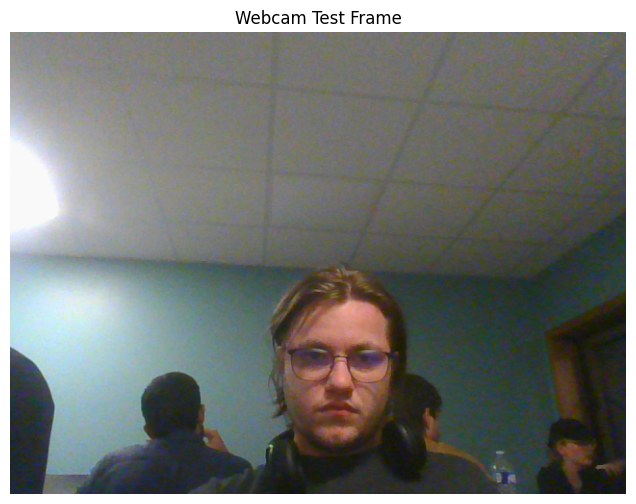

In [20]:
# Test webcam
camera_id = 0
cap = cv2.VideoCapture(camera_id)

if cap.isOpened():
    # Set camera properties for better performance
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    # Capture a test frame
    ret, test_frame = cap.read()
    if ret:
        print("✓ Webcam initialized successfully!")
        print(f"  Resolution: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}x{int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
        print(f"  FPS: {int(cap.get(cv2.CAP_PROP_FPS))}")
        
        # Display test frame
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
        plt.title("Webcam Test Frame")
        plt.axis('off')
        plt.show()
    else:
        print("❌ Could not capture frame from webcam")
    
    cap.release()
else:
    print(f"❌ Could not open camera {camera_id}")
    print("Make sure your webcam is connected and not being used by another application.")

In [21]:
# Processing state
mode = 'swap'  # 'swap', 'blur', 'pixelate', 'original'
debug_mode = False

# Performance tracking
fps = 0
frame_count = 0
start_time = time.time()

# Initialize webcam
cap = cv2.VideoCapture(camera_id)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

print("="*60)
print("🎥 Real-Time Face Swapping Started!")
print("="*60)
print("\nControls:")
print("  'q' or ESC - Quit")
print("  's' - Save screenshot")
print("  'f' - Face swap mode")
print("  'b' - Blur mode")
print("  'p' - Pixelate mode")
print("  'o' - Original mode")
print("  'd' - Toggle debug mode")
print("  SPACE - Capture reference face from webcam")
print("="*60)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to read from camera")
            break
        
        # Mirror the frame for more natural interaction
        frame = cv2.flip(frame, 1)
        
        # Convert to grayscale for detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100, 100))
        
        # Process based on mode
        result = frame.copy()
        
        for face in faces:
            x, y, w, h = face
            
            if mode == 'original':
                # Draw rectangle only
                cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
            elif mode == 'blur':
                result = blur_face(result, face)
                cv2.rectangle(result, (x, y), (x+w, y+h), (255, 0, 0), 2)
                
            elif mode == 'pixelate':
                result = pixelate_face(result, face)
                cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
                
            elif mode == 'swap':
                if source_image is not None and facemark is not None:
                    # Get landmarks for target face
                    success, landmarks = facemark.fit(gray, np.array([face]))
                    if success and len(landmarks) > 0:
                        target_landmarks = landmarks[0][0].astype(np.int32)
                        result = swap_face(source_image, source_landmarks, result, target_landmarks, debug_mode)
                    else:
                        # Fallback: just draw rectangle
                        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 255), 2)
                else:
                    cv2.rectangle(result, (x, y), (x+w, y+h), (128, 128, 128), 2)
                    cv2.putText(result, "No source face", (x, y-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (128, 128, 128), 2)
        
        # Update FPS
        frame_count += 1
        elapsed = time.time() - start_time
        if elapsed > 1.0:
            fps = frame_count / elapsed
            frame_count = 0
            start_time = time.time()
        
        # Draw UI
        h, w = result.shape[:2]
        
        # Background for text
        overlay = result.copy()
        cv2.rectangle(overlay, (5, 5), (300, 120), (0, 0, 0), -1)
        result = cv2.addWeighted(overlay, 0.5, result, 0.5, 0)
        
        # Mode indicator
        mode_text = f"Mode: {mode.upper()}"
        color = {
            'swap': (0, 255, 0),
            'blur': (255, 0, 0),
            'pixelate': (0, 0, 255),
            'original': (255, 255, 255)
        }.get(mode, (255, 255, 255))
        
        cv2.putText(result, mode_text, (10, 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # FPS
        cv2.putText(result, f"FPS: {fps:.1f}", (10, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Face count
        cv2.putText(result, f"Faces: {len(faces)}", (10, 75),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Source status (FIX: use 'is not None' instead of truthy check)
        source_status = "✓ Loaded" if source_image is not None else "✗ None"
        source_color = (0, 255, 0) if source_image is not None else (0, 0, 255)
        cv2.putText(result, f"Source: {source_status}", (10, 100),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, source_color, 1)
        
        # Debug mode indicator
        if debug_mode:
            cv2.putText(result, "DEBUG", (w-100, 25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        
        # Display
        cv2.imshow('Real-Time Face Swapping', result)
        
        # Handle keyboard input
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q') or key == 27:  # 'q' or ESC
            print("\n👋 Quitting...")
            break
        elif key == ord('s'):
            # Save screenshot
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"screenshot_{timestamp}.jpg"
            filepath = os.path.join("../assets", filename)
            os.makedirs("../assets", exist_ok=True)
            cv2.imwrite(filepath, result)
            print(f"✓ Screenshot saved: {filepath}")
        elif key == ord('f'):
            mode = 'swap'
            print("→ Face swap mode")
        elif key == ord('b'):
            mode = 'blur'
            print("→ Blur mode")
        elif key == ord('p'):
            mode = 'pixelate'
            print("→ Pixelate mode")
        elif key == ord('o'):
            mode = 'original'
            print("→ Original mode")
        elif key == ord('d'):
            debug_mode = not debug_mode
            print(f"→ Debug mode: {'ON' if debug_mode else 'OFF'}")
        elif key == 32:  # SPACE
            # Capture reference face from webcam
            print("📸 Capturing reference face...")
            if len(faces) > 0:
                face = faces[0]
                if facemark is not None:
                    success, landmarks = facemark.fit(gray, np.array([face]))
                    if success and len(landmarks) > 0:
                        source_image = frame.copy()
                        source_face = face
                        source_landmarks = landmarks[0][0].astype(np.int32)
                        print(f"✓ Reference face captured with {len(source_landmarks)} landmarks")
                    else:
                        source_image = frame.copy()
                        source_face = face
                        source_landmarks = estimate_landmarks(face)
                        print("✓ Reference face captured (estimated landmarks)")
                else:
                    source_image = frame.copy()
                    source_face = face
                    source_landmarks = estimate_landmarks(face)
                    print("✓ Reference face captured (estimated landmarks)")
            else:
                print("❌ No face detected in frame")

except KeyboardInterrupt:
    print("\n\n👋 Interrupted by user")
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("✓ Camera released and windows closed")

🎥 Real-Time Face Swapping Started!

Controls:
  'q' or ESC - Quit
  's' - Save screenshot
  'f' - Face swap mode
  'b' - Blur mode
  'p' - Pixelate mode
  'o' - Original mode
  'd' - Toggle debug mode
  SPACE - Capture reference face from webcam

👋 Quitting...
✓ Camera released and windows closed

👋 Quitting...
✓ Camera released and windows closed


## 🎉 Conclusion

Vous avez maintenant un système complet de face swapping en temps réel !

### Fonctionnalités implémentées:
✅ Détection de visages avec Haar Cascade  
✅ Détection de 68 points de repère faciaux  
✅ Extension des landmarks pour inclure le front (5 points supplémentaires)  
✅ Triangulation de Delaunay pour le mapping géométrique  
✅ Transformation affine pour warper les triangles  
✅ Seamless cloning pour un rendu naturel  
✅ Modes d'anonymisation (blur et pixelate)  
✅ Capture de visage de référence depuis la webcam  
✅ Affichage du FPS en temps réel  
✅ Sauvegarde de screenshots

## 10. Real-Time Processing Loop 🎥

**Run this cell to start real-time face swapping!**

This is the main interactive loop that processes webcam frames in real-time.

### Controls:
- **'q' or ESC**: Quit
- **'f'**: Face swap mode (default)
- **'b'**: Blur mode
- **'p'**: Pixelate mode
- **'o'**: Original (no processing)
- **'s'**: Save screenshot
- **'d'**: Toggle debug mode (show landmarks)
- **SPACE**: Capture reference face from webcam

The window will show:
- Current processing mode
- FPS (frames per second)
- Number of faces detected
- Source face status

## 9. Initialize Webcam

Test if the webcam is available and working properly.

## 8. Load and Process Source Face Image

Load a source face image for swapping. You can change the path to use your own image!

## 7. Face Anonymization Functions

Functions for blur and pixelate anonymization modes.

## 6. Face Swapping Function

The main face swapping algorithm using Delaunay triangulation and seamless cloning.

## 5. Triangle Warping Functions

Implement affine transformation to warp triangular regions from source face to target face.

## 4. Helper Functions - Landmark Processing

Create functions to estimate facial landmarks (fallback) and extend landmarks to include forehead points.

## 3. Initialize Face Detection Components

Initialize the Haar Cascade face detector and the LBF facial landmark detector.

## 2. Download Facial Landmark Model

Download the LBF (Local Binary Features) model for detecting 68 facial landmarks. This model is essential for precise face mapping and swapping.

## 1. Import Required Libraries

Import all necessary libraries for face detection, landmark detection, triangulation, and webcam processing.